<a href="https://colab.research.google.com/github/GallardoCoriaMarcelo/Laboratorios/blob/main/Laboratorio2_Reg-Log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicion de programación - Regresión Logistica

En este ejercicio se implementa regresion logistica y se aplica a dos diferentes datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np

# Librerias para graficar
from matplotlib import pyplot

# Modulo de optimización de scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

import pandas as pd

## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística para predecir si un estudiante será admitido en una universidad. Suponga que es el administrador de un departamento universitario y desea determinar las posibilidades de admisión de cada solicitante en función de sus resultados en dos exámenes. Tiene datos históricos de solicitantes anteriores que puede usar como un conjunto de capacitación para la regresión logística. Para cada ejemplo de capacitación, se tiene las calificaciones del solicitante en dos exámenes y la decisión de admisión. Su tarea es crear un modelo de clasificación que calcule la probabilidad de admisión de un solicitante en función de los puntajes de esos dos exámenes.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [29]:
# Cargar datos
# La primera columna contiene los resultados (labels) que se quieren predecir, 1=Goodware -1=Malware
# Las X son caracteres de los programas, en total son 500 y se analiza la cantidad de veces que se reproducen
url = 'https://raw.githubusercontent.com/GallardoCoriaMarcelo/Laboratorios/main/DynamicMalwareMatrix2.csv'
data = pd.read_csv(url)
#Selecciona el 80% del dataset para entrenamiento
porcentaje = 0.8
data_muestra = data.sample(frac=porcentaje, random_state=42)

data.head()
y = data_muestra.iloc[:, 0]      # Primera columna como Y
X = data_muestra.iloc[:, 1:501]    # Demas columnas como X
print(X)
print(y)

       00  0000  0000000  000000000046  00021401  00c04fc295ee  01  0156250  \
13491   0     6        0             3         0             0   0        0   
283     0     0        0             0         0             0   0        0   
3265    0     0        0             0         0             0   0        0   
16583   0     0        0             0         0             0   0        0   
15081   0     0        0             0         0             0   0        0   
...    ..   ...      ...           ...       ...           ...  ..      ...   
15198   0     0        0             0         0             0   0        0   
16061   0     0        0             0         0             0   0        0   
3303    0     0        0             0         0             0   0        0   
15549   0     0        0             0         0             0   0        0   
18074   0     0        0             0         0             0   0        0   

       02  03  ...  windowsruntime  winevt  wmiprvs

### 1.1 Visualizar los datos

Antes de comenzar a implementar cualquier algoritmo de aprendizaje, siempre es bueno visualizar los datos si es posible. Mostramos los datos en una gráfica bidimensional llamando a la función `plotData`. Se completará el código en `plotData` para que muestre una figura donde los ejes son los dos puntajes de los dos examenes, los ejemplos positivos y negativos se muestran con diferentes marcadores.

In [30]:
def plotData(X, y):
    # Gragica los puntos de datos X y y en una nueva figura. Grafica los puntos de datos con * para los positivos y
    # o para los negativos.

    # Crea una nueva figura
    fig = pyplot.figure()

    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)


Se llama a la función implementada para mostrar los datos cargados:

In [12]:
plotData(X, y)
# adiciona etiquetas para los ejes
pyplot.xlabel('Calificación Examen 1')
pyplot.ylabel('Calificación Examen 2')
pyplot.legend(['Admitido', 'No admitido'])
pass

InvalidIndexError: (0        False
1        False
2        False
3        False
4         True
         ...  
24137    False
24138    False
24139     True
24140     True
24141    False
Name: labels, Length: 24142, dtype: bool, 0)

<Figure size 640x480 with 0 Axes>

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [31]:
def sigmoid(z):
    # Calcula la sigmoide de una entrada z
    # convierte la intrada a un arreglo numpy
    z = np.array(z)

    g = np.zeros(z.shape)

    g = 1 / (1 + np.exp(-z))

    return g

Se calcula el valor de la sigmoide aplicando la funcion sigmoid con `z=0`, se debe obtener un resultado de 0.5. RE recomienda experimentar con otros valores de `z`.

In [32]:
# Prueba la implementacion de la funcion sigmoid
z = 21
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 21 ) =  0.9999999992417439


<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Se implementa la funcion cost y gradient, para la regresión logistica. Antes de continuar es importante agregar el termino de intercepcion a X.

In [33]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
X = np.concatenate([np.ones((m, 1)), X], axis=1)

La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [34]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [35]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)

        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

<ipython-input-34-9bf1ce321844>:7: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))


theta calculado por el descenso por el gradiente: [-7.27363279e-03  2.57858422e-02 -3.10540528e-03 -4.64176577e-03
 -2.85193915e-03 -1.05547248e-03  4.80780602e-03  2.50958762e-02
 -4.46293413e-03 -9.96467544e-03  4.21334473e-03 -1.34457694e-02
 -7.60008282e-03 -4.07933835e-02 -1.35793421e-02  3.28243819e-02
  1.41737584e-03  1.81666028e-02  1.68912428e-02  1.21321674e-02
 -2.79426661e-03 -1.26230681e-01  2.20975889e-02 -2.37296945e-02
  4.25292023e-03  2.05727612e-02  2.71439580e-02  1.21798164e-01
 -2.01232692e-02  1.41737584e-03  5.92347283e-02 -1.08220928e-02
 -7.99651890e-03 -9.36578111e-04  4.79167855e-03  2.35234045e-02
 -4.46546375e-03 -1.59429430e-02 -8.66358373e-01 -2.46830741e-03
 -1.08857559e-02  1.65871826e-02 -6.51285719e-01 -5.89779497e-01
 -4.75774665e-01 -7.53646571e-03  5.64475805e-02 -3.64868854e-02
  2.06629970e-02 -2.44094942e-02 -4.77883578e-02 -5.10402608e-04
  2.21116849e-01 -1.95700276e-02 -3.40536440e-03 -3.76536415e-03
 -1.72150766e-02  1.55769782e-02  5.6563

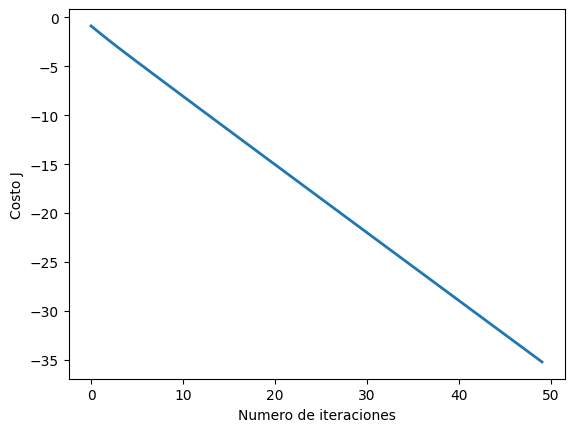

In [36]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.001
num_iters = 100

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(501)
theta, J_history = descensoGradiente(theta, X, y, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))



In [39]:
#Selecciona el 20%restante para pruebas
data_prueba = data.drop(data_muestra.index)

y_prueba = data_prueba.iloc[:, 0]
X_prueba = data_prueba.iloc[:, 1:501]

# verificar si ingresa o no a la universidad
X_array_prueba = X_prueba.values
malware = sigmoid(np.dot(X_array_prueba, theta))   # Se debe cambiar esto

print('Malware = -1, Goodware = 1'.format(malware))

ValueError: shapes (4828,500) and (501,) not aligned: 500 (dim 1) != 501 (dim 0)

In [25]:
def costFunction(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)

    return J, grad

Se prueba la funcion `costFunction` utilizando dos casos de prueba para $\theta$.

In [26]:
# Inicializacion de parametros de ajuste
initial_theta = np.zeros(n+1)
print(initial_theta)
cost, grad = costFunction(initial_theta, X, y)

print('Costo en theta inicial (zeros): {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.693\n')
print(grad)
print('Gradiente en theta inicial (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Gradiente esperado (aproximado):\n\t[-0.1000, -12.0092, -11.2628]\n')



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [27]:
# Calcula y muestra el costo y el gradiente con valores de theta diferentes a cero

test_theta = np.array([-24, 0.2, 0.2])
#test_theta = np.array([-11.74749157, 0.09927308, 0.09316497])
print(test_theta)
cost, grad = costFunction(test_theta, X, y)

print('Costo en theta prueba: {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.218\n')

print('Gradiente en theta prueba:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Gradiente esperado (aproximado):\n\t[0.043, 2.566, 2.647]')

[-24.    0.2   0.2]


ValueError: shapes (24142,501) and (3,) not aligned: 501 (dim 1) != 3 (dim 0)

#### 1.2.3 Parámetros de aprendizaje usando `scipy.optimize`

En el codigo anterior se encontró los parámetros óptimos de un modelo de regresión lineal al implementar el descenso de gradiente. Se implemento una función de costo y se calculó su gradiente, utilizando el algoritmo del descenso por el gradiente.

En lugar de realizar los pasos del descenso por el gradiente, se utilizará el [módulo `scipy.optimize`] (https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una biblioteca de computación numérica para `python`. Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:

Para la regresión logística, se desea optimizar la función de costo $J(\theta)$ con los parámetros $\theta$.
Concretamente, se va a utilizar `optimize.minimize` para encontrar los mejores parámetros $\theta$ para la función de costo de regresión logística, dado un dataset fijo (de valores X e y). Se pasara a `optimize.minimize` las siguientes entradas:

- `costFunction`: Una función de costo que, cuando se le da el dataset de entrenamiento y un $\theta$ particular, calcula el costo de regresión logística y el gradiente con respecto a $\theta$ para el dataset(X, y). Es importante tener en cuenta que solo se pasa el nombre de la función sin el paréntesis. Esto indica que solo proporcionamos una referencia a esta función y no evaluamos el resultado de esta función.
- `initial_theta`: Los valores iniciales de los parametros que se tratan de optimizar.
- `(X, y)`: Estos son argumentos adicionales a la funcion de costo.
- `jac`: Indicación si la función de costo devuelve el jacobiano (gradiente) junto con el valor de costo. (True)
- `method`: Método / algoritmo de optimización a utilizar
- `options`: Opciones adicionales que pueden ser específicas del método de optimización específico. Solo se indica al algoritmo el número máximo de iteraciones antes de que termine.

Si se ha completado la `costFunction` correctamente,`optimize.minimize` convergerá en los parámetros de optimización correctos y devolverá los valores finales del costo y $\theta$ en un objeto de clase.

Al usar `optimize.minimize`, no se tuvo que escribir ningún bucle ni establecer una tasa de aprendizaje como se hizo para el descenso de gradientes. Todo esto se hace mediante `optimize.minimize`: solo se necesita proporcionar una función que calcule el costo y el gradiente.

A continuación, se tiene el código para llamar a `optimize.minimize` con los argumentos correctos.

In [ ]:
# Establecer las opciones para optimize.minimize
options= {'maxiter': 1000}

# revisar la documentacion de scipy's optimize.minimize para mayor descripcion de los parametros
# La funcion devuekve un objeto `OptimizeResult`
# Se utiliza el algoritmo de Newton truncado para la optimización.
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# la propiedad fun del objeto devuelto por `OptimizeResult`
# contiene el valor del costFunction de un theta optimizado
cost = res.fun

# Theta optimizada esta en la propiedad x
theta = res.x

# Imprimir theta en la pantalla
print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.203\n');

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Theta esperado (aproximado):\n\t[-25.161, 0.206, 0.201]')

Costo con un valor de theta encontrado por optimize.minimize: 0.203
Costo esperado (aproximado): 0.203

theta:
	[-25.161, 0.206, 0.201]
Theta esperado (aproximado):
	[-25.161, 0.206, 0.201]


Una vez que se completa `optimize.minimize`, se usa el valor final de $\theta$ para visualizar el límite de decisión en los datos de entrenamiento.

Para hacerlo, se implementa la función `plotDecisionBoundary` para trazar el límite de decisión sobre los datos de entrenamiento.

In [ ]:
def plotDecisionBoundary(plotData, theta, X, y):
    """
    Grafica los puntos X y Y en una nueva figura con un limite de desicion definido por theta.
    the data points X and y into a new figure with the decision boundary defined by theta.
    Grafica los puntos con * para los ejemplos positivos y con o para los ejemplos negativos.

    Parametros:
    ----------
    plotData : func
        A function reference for plotting the X, y data.

    theta : array_like
        Parametros para la regresion logistica. Un vecto de la forma (n+1, ).

    X : array_like
        Data set de entrada. Se supone que X es una de las siguientes:
            1) Matriz Mx3, donde la primera columna es una columna de unos para intercepción.
            2) Matriz MxN, N> 3, donde la primera columna son todos unos.

    y : array_like
        Vector de datos de etiquetas de la forma (m, ).
    """
    # hacer que theta sera un arreglo numpy
    theta = np.array(theta)

    # Graficar los datos (recordar que la primera columna en X es la intercepción)
    plotData(X[:, 1:3], y)

    if X.shape[1] <= 3:
        # Solo se requieren 2 puntos para definir una linea, para lo cual se eligen dos puntos finales
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

        # Calcular la línea límite de decisión
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        print(plot_x)
        print(plot_y)
        # Graficar y ajustar los ejes para una mejor visualización
        pyplot.plot(plot_x, plot_y)

        # Leyenda, especifica para el ejercicio
        pyplot.legend(['Admitido', 'No admitido', 'Limite de decisión'])
        pyplot.xlim([30, 100])
        pyplot.ylim([30, 100])
    else:
        # Rango de la grilla
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((u.size, v.size))
        # Evalua z = theta*x sobre la grilla
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                z[i, j] = np.dot(mapFeature(ui, vj), theta)

        z = z.T  # importante transponer z antes de llamar al contorno
        # print(z)

        # Plot z = 0
        pyplot.contour(u, v, z, levels=[0], linewidths=2, colors='g')
        pyplot.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)


[ 28.05882245 101.8278578 ]
[96.16598102 20.65402806]


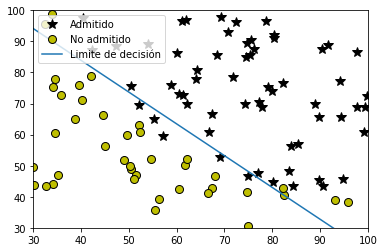

In [ ]:
# Graficar limites
plotDecisionBoundary(plotData, theta, X, y)

<a id="section4"></a>
#### 1.2.4 Evaluación de la regresión logistica

Después de aprender los parámetros, se puede usar el modelo para predecir si un estudiante en particular será admitido. Para un estudiante con una puntuación en el Examen 1 de 45 y una puntuación en el Examen 2 de 85, debe esperar ver una probabilidad de admisión de 0,776. Otra forma de evaluar la calidad de los parámetros que hemos encontrado es ver qué tan bien predice el modelo aprendido en nuestro conjunto de entrenamiento.

In [ ]:
def predict(theta, X):
    """
    Predecir si la etiqueta es 0 o 1 mediante regresión logística aprendida.
    Calcula las predicciones para X usando un umbral en 0.5 (es decir, si sigmoide (theta.T * x)> = 0.5, predice 1)

    Parametros
    ----------
    theta : array_like
        Parametros para regresion logistica. Un vecto de la forma (n+1, ).

    X : array_like
        Datos utilizados para el calculo de las predicciones.
        La fila es el numero de los puntos para calcular las predicciones,
        y las columnas con el numero de caracteristicas.

    Devuelve
    -------
    p : array_like
        Predicciones y 0 o 1 para cada fila en X.
    """
    m = X.shape[0] # Numero de ejemplo de entrenamiento

    p = np.zeros(m)

    p = np.round(sigmoid(X.dot(theta.T)))
    return p

Una vez entrenado el modelo se procede a realizar la prediccion y evaluación de los resultados de predecir cual es el valor que vota el modelo para todos los datos utilizados en el entrenamiento.

In [ ]:
#  Predice la probabilidad de ingreso para un estudiante con nota de 45 en el examen 1 y nota de 85 en el examen 2
prob = sigmoid(np.dot([1, 45, 85], theta))
print('Para un estudiante con notas de 45 y 85, se predice una probabilidad de admisión de: {:.3f}%'.format(prob))
print('Valor esperado: 0.775 +/- 0.002\n')

# Compute accuracy on our training set
p = predict(theta, X)
print('Precisión de entrenamiento: {:.2f} %'.format(np.mean(p == y) * 100))
print('Precisión esperada (aproximadamente): 89.00 %')

Para un estudiante con notas de 45 y 85, se predice una probabilidad de admisión de: 0.776%
Valor esperado: 0.775 +/- 0.002

Precisión de entrenamiento: 89.00 %
Precisión esperada (aproximadamente): 89.00 %
